In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix
from HPA_CC.data.dataset import RefCLSDM, RefImDM
from HPA_CC.models.train import find_checkpoint_file, ClassifierLit, PseudoRegressorLit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model_name = "HPA DINO Classifier"
repr_type = "hpa_dino" # "dino", "hpa_dino", or "conv"
model_hash = "1gu6u2qu" # hash of the model to use
log_dirs_home = Path("/data/ishang/pseudotime_pred/")
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = True # were intensity statistics added to the embedding? (not used from conv)
label_type = "phase" # "phase", "angle", or "pseudotime"
scope = True
split = (0.64, 0.16, 0.2)
data_dir = Path("/data/ishang/FUCCI-dataset-well")
data_name = "minimal"
device = "cuda:0"

In [ ]:
if repr_type == "conv":
    dataset = RefImDM(data_dir, data_name, 32, 1, split, label_type, scope)
else:
    dataset = RefCLSDM(data_dir, data_name, 32, 1, split, (repr_type == "hpa_dino"), label_type, scope, int_stats)

Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape: torch.Size([31732, 1536])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt
tensor(0., dtype=torch.float64) tensor(1.6130, dtype=torch.float64)
X shape: torch.Size([31732, 2048])
Y shape: torch.Size([31732, 4])


In [ ]:
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
if label_type == "phase":
    model = ClassifierLit.load_from_checkpoint(checkpoint_file)
else:
    model = PseudoRegressorLit.load_from_checkpoint(checkpoint_file)
model.to(device)
model.eval()


ClassifierLit(
  (model): Classifier(
    (model): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=2048, out_features=4, bias=True)
    )
    (loss_fn): FocalLoss(alpha=None, gamma=2.0, ignore_index=-100, reduction='mean')
  )
)

In [ ]:
preds_list = []
with torch.no_grad():
    for batch in iter(dataset.test_dataloader()):
        x, y = batch
        x = x.to(device)
        preds_list.append(model(x).cpu())
preds = torch.cat(preds_list, dim=0).numpy()
labels = dataset.dataset.Y[dataset.split_indices["test"]]
print(preds.shape, labels.shape)
preds = np.argmax(preds, axis=1)
labels = np.argmax(labels, axis=1)
print(preds.shape, labels.shape)

(6346, 4) torch.Size([6346, 4])
(6346,) torch.Size([6346])


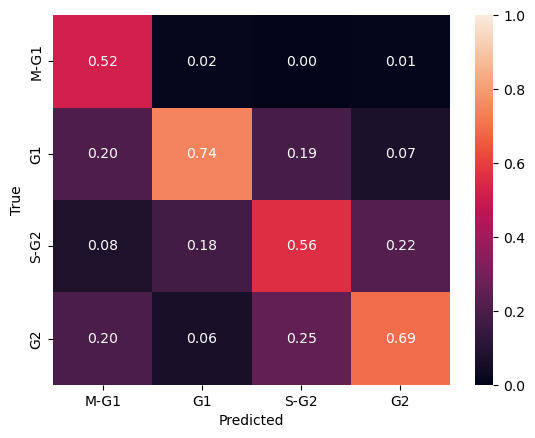

In [ ]:
classes = ["M-G1", "G1", "S-G2", "G2"]
filler = np.arange(len(classes))
preds_ = np.concatenate((preds, filler))
labels_ = np.concatenate((labels, filler))
cm = confusion_matrix(labels_, preds_).astype(np.float32)
cm = cm - np.identity(len(classes))
cm = cm / np.sum(cm, axis=0, keepdims=True)
ax = sns.heatmap(cm, annot=True, fmt=".2f", vmin=0, vmax=1.0)
ax.set_xlabel("Predicted")
ax.xaxis.set_ticklabels(classes)
ax.set_ylabel("True")
ax.yaxis.set_ticklabels(classes)
plt.title(f"Confusion Matrix for {model_name} (Normalized over Prediction Class)")
plt.show()